# Multivariate Exploratory Analysis - Marketing Campaigns
## Context and Objective
Assess behavioral patterns and factors associated with campaign response based on customer history.

## Conclusion

The most relevant factors explaining customer response to marketing campaigns are total spend history, income, total tenure as a customer, age, and total prior purchases. In short, loyal customers are more likely to accept marketing campaigns.

Education level and marital status do not appear to be relevant factors for explaining campaign response, so we applied hypothesis testing.

Testing the hypothesis that there is a significant difference in mean income between customers with and without higher education showed that a difference exists, and higher education levels have higher average income.

Therefore, the company should segment marketing campaigns for different audiences and target campaigns based on income and education level, while also considering total spend history, customer tenure, age, and prior purchases.

## Reproducibility
- Data: `dataset.csv` (local project file).
- Randomness: models use `random_state=43` when applicable.
- Environment: record Python and core package versions in the execution environment.

In [1]:
# Imports
import sklearn
import scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

## Data Loading

In [2]:
# Carrega o dataset
df = pd.read_csv("dataset.csv")

In [3]:
# Shape
df.shape

(2237, 25)

In [4]:
# Sample of the data
df.head()

,ID,Ano_Nascimento,Educacao,Estado_Civil,Renda,Criancas_Em_Casa,Adolescentes_Em_Casa,Data_Cadastro_Cliente,Gasto_Vinhos,Gasto_Frutas,...,Num_Compras_Web,Num_Compras_Catalogo,Num_Compras_Loja,Num_Visitas_Web_Mes,Aceitou_Campanha_1,Aceitou_Campanha_2,Aceitou_Campanha_3,Aceitou_Campanha_4,Aceitou_Campanha_5,Aceitou_Campanha_6
0,9970,1977,Graduação,Casado,"$55,375.00",0,1,10/17/13,42,11,...,1,1,6,2,0,0,0,0,0,0
1,4002,1960,PhD,Casado,"$77,037.00",0,1,10/13/13,463,96,...,7,7,12,3,0,0,0,0,0,0
2,10914,1970,Graduação,Solteiro,"$24,163.00",1,1,2010-12-13,4,1,...,1,0,3,4,0,0,0,0,0,0
3,7279,1969,PhD,Casado,"$69,476.00",0,0,9/30/13,260,86,...,4,6,4,2,0,0,0,0,0,0
4,10582,1979,Graduação,Casado,"$72,063.00",0,1,2007-03-13,180,32,...,5,2,12,2,0,0,0,0,0,0


In [5]:
# Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2237 entries, 0 to 2236
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ID                         2237 non-null   int64 
 1    Ano_Nascimento            2237 non-null   int64 
 2    Educacao                  2237 non-null   object
 3    Estado_Civil              2237 non-null   object
 4    Renda                     2213 non-null   object
 5    Criancas_Em_Casa          2237 non-null   int64 
 6    Adolescentes_Em_Casa      2237 non-null   int64 
 7    Data_Cadastro_Cliente     2237 non-null   object
 8    Gasto_Vinhos              2237 non-null   int64 
 9    Gasto_Frutas              2237 non-null   int64 
 10   Gasto_Carnes              2237 non-null   int64 
 11   Gasto_Peixes              2237 non-null   int64 
 12   Gasto_Doces               2237 non-null   int64 
 13   Gasto_Outros              2237 non-null   int64 
 14   Num_Com

## Data Cleaning and Preparation

In [6]:
# Remove extra spaces from column titles
df.columns = df.columns.str.replace(' ', '') 

In [7]:
# Remove the $ character from Renda for numeric conversion
df['Renda'] = df['Renda'].str.replace('$', '').str.replace(',', '').astype(float) 

In [8]:
# Convert date column to datetime
df['Data_Cadastro_Cliente'] = pd.to_datetime(df['Data_Cadastro_Cliente']) 

In [9]:
# Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2237 entries, 0 to 2236
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   ID                        2237 non-null   int64         
 1   Ano_Nascimento            2237 non-null   int64         
 2   Educacao                  2237 non-null   object        
 3   Estado_Civil              2237 non-null   object        
 4   Renda                     2213 non-null   float64       
 5   Criancas_Em_Casa          2237 non-null   int64         
 6   Adolescentes_Em_Casa      2237 non-null   int64         
 7   Data_Cadastro_Cliente     2237 non-null   datetime64[ns]
 8   Gasto_Vinhos              2237 non-null   int64         
 9   Gasto_Frutas              2237 non-null   int64         
 10  Gasto_Carnes              2237 non-null   int64         
 11  Gasto_Peixes              2237 non-null   int64         
 12  Gasto_Doces         

In [10]:
# Sample of the data
df.head()

,ID,Ano_Nascimento,Educacao,Estado_Civil,Renda,Criancas_Em_Casa,Adolescentes_Em_Casa,Data_Cadastro_Cliente,Gasto_Vinhos,Gasto_Frutas,...,Num_Compras_Web,Num_Compras_Catalogo,Num_Compras_Loja,Num_Visitas_Web_Mes,Aceitou_Campanha_1,Aceitou_Campanha_2,Aceitou_Campanha_3,Aceitou_Campanha_4,Aceitou_Campanha_5,Aceitou_Campanha_6
0,9970,1977,Graduação,Casado,55375.0,0,1,2013-10-17,42,11,...,1,1,6,2,0,0,0,0,0,0
1,4002,1960,PhD,Casado,77037.0,0,1,2013-10-13,463,96,...,7,7,12,3,0,0,0,0,0,0
2,10914,1970,Graduação,Solteiro,24163.0,1,1,2010-12-13,4,1,...,1,0,3,4,0,0,0,0,0,0
3,7279,1969,PhD,Casado,69476.0,0,0,2013-09-30,260,86,...,4,6,4,2,0,0,0,0,0,0
4,10582,1979,Graduação,Casado,72063.0,0,1,2007-03-13,180,32,...,5,2,12,2,0,0,0,0,0,0


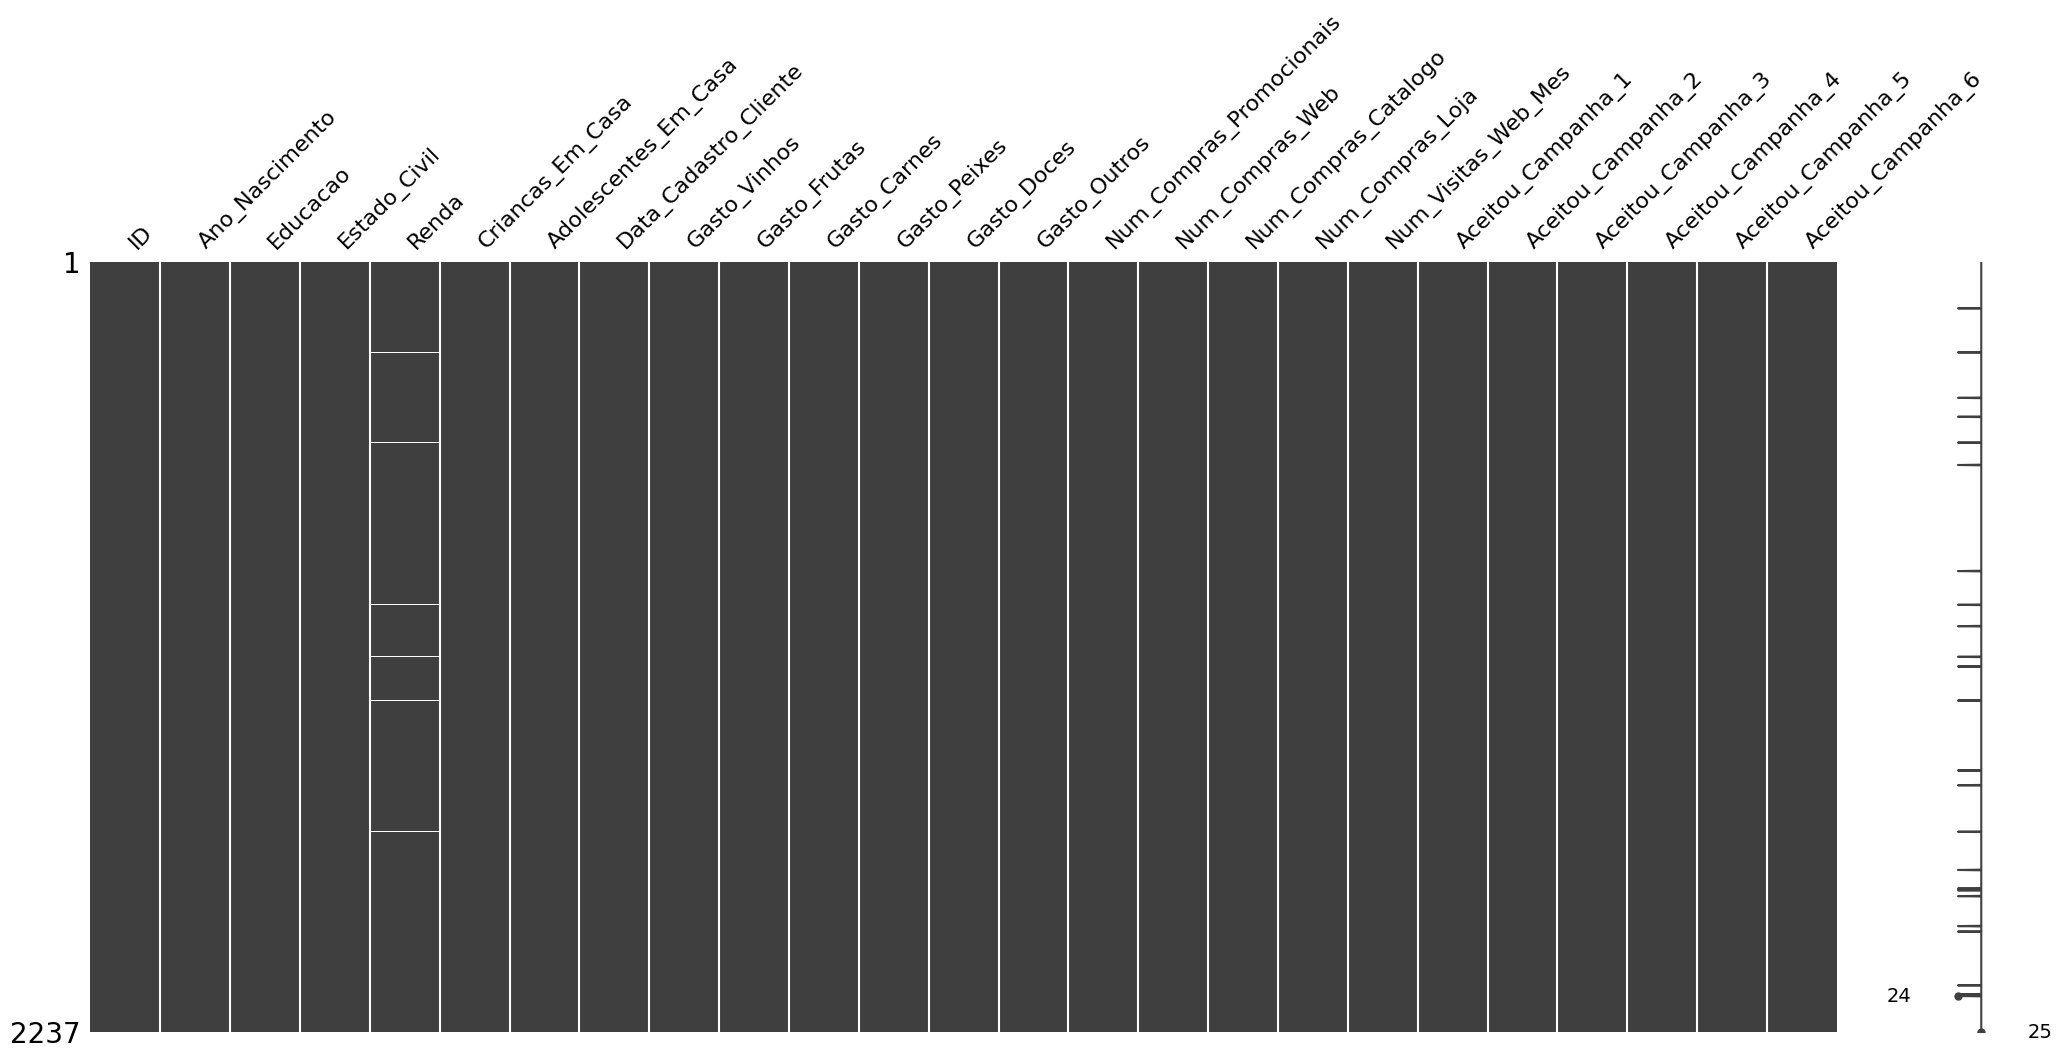

In [11]:
# Missing values matrix
msno.matrix(df)
plt.show()

**Figure 1 - Missing values matrix.**
Interpretation: The visualization highlights missingness by variable and guides missing-data treatment.

In [12]:
# Sum of missing values
missing_values = df.isnull().sum().sort_values(ascending = False)

In [13]:
missing_values

Renda                       24
ID                           0
Gasto_Outros                 0
Aceitou_Campanha_5           0
Aceitou_Campanha_4           0
Aceitou_Campanha_3           0
Aceitou_Campanha_2           0
Aceitou_Campanha_1           0
Num_Visitas_Web_Mes          0
Num_Compras_Loja             0
Num_Compras_Catalogo         0
Num_Compras_Web              0
Num_Compras_Promocionais     0
Gasto_Doces                  0
Ano_Nascimento               0
Gasto_Peixes                 0
Gasto_Carnes                 0
Gasto_Frutas                 0
Gasto_Vinhos                 0
Data_Cadastro_Cliente        0
Adolescentes_Em_Casa         0
Criancas_Em_Casa             0
Estado_Civil                 0
Educacao                     0
Aceitou_Campanha_6           0
dtype: int64

In [14]:
# Filter those that are different from zero
print(missing_values.loc[missing_values != 0])

Renda    24
dtype: int64


Before treating missing values, we assessed outliers in the income variable to guide the treatment strategy.

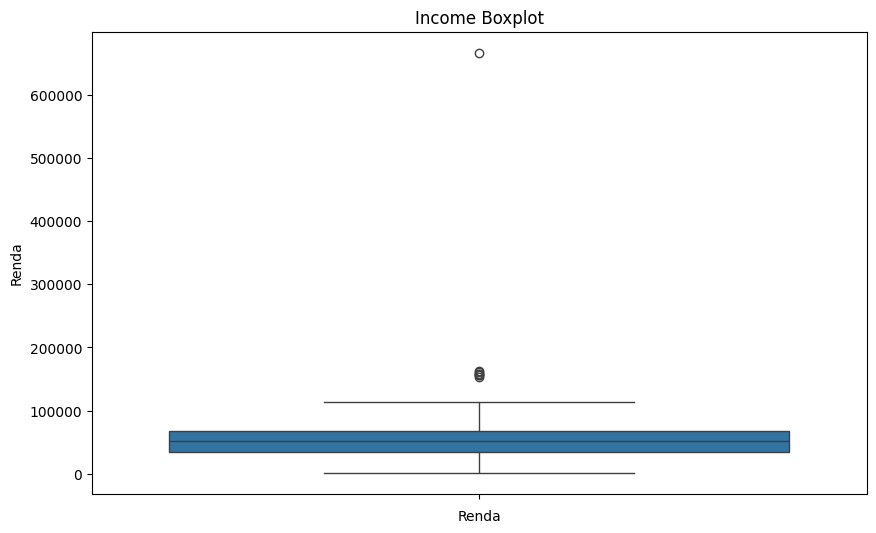

In [15]:
# Boxplot to identify outliers in the 'Renda' column
plt.figure(figsize = (10, 6))
sns.boxplot(df['Renda'])
plt.title('Income Boxplot')
plt.xlabel('Renda')
plt.show()

**Figure 2 - Income boxplot (before outlier treatment).**
Interpretation: Highlights extreme income values and supports the treatment decision.

There are indications of outliers; we confirm using a statistical rule.

In [16]:
# Calculating the IQR for the 'Renda' column
Q1 = df['Renda'].quantile(0.25)
Q3 = df['Renda'].quantile(0.75)
IQR = Q3 - Q1

In [17]:
# Define bounds to consider a point as an outlier
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [18]:
# Identificando os outliers
outliers = df[(df['Renda'] < lower_bound) | (df['Renda'] > upper_bound)]
outliers

,ID,Ano_Nascimento,Educacao,Estado_Civil,Renda,Criancas_Em_Casa,Adolescentes_Em_Casa,Data_Cadastro_Cliente,Gasto_Vinhos,Gasto_Frutas,...,Num_Compras_Web,Num_Compras_Catalogo,Num_Compras_Loja,Num_Visitas_Web_Mes,Aceitou_Campanha_1,Aceitou_Campanha_2,Aceitou_Campanha_3,Aceitou_Campanha_4,Aceitou_Campanha_5,Aceitou_Campanha_6
325,4931,1977,Graduação,Casado,157146.0,0,0,2013-04-29,1,0,...,0,28,0,1,0,0,0,0,0,0
497,1501,1982,PhD,Casado,160803.0,0,0,2008-04-12,55,16,...,0,28,1,0,0,0,0,0,0,0
526,9432,1977,Graduação,Casado,666666.0,1,0,2006-02-13,9,14,...,3,1,3,6,0,0,0,0,0,0
730,1503,1976,PhD,Casado,162397.0,1,1,2006-03-13,85,1,...,0,0,1,1,0,0,0,0,0,0
851,5336,1971,Mestrado,Casado,157733.0,1,0,2006-04-13,39,1,...,1,0,1,1,0,0,0,0,0,0
1787,5555,1975,Graduação,Divorciado,153924.0,0,0,2002-07-14,1,1,...,0,0,0,0,0,0,0,0,0,0
1886,11181,1949,PhD,Casado,156924.0,0,0,2013-08-29,2,1,...,0,0,0,0,0,0,0,0,0,0
2165,8475,1973,PhD,Casado,157243.0,0,1,2003-01-14,20,2,...,0,22,0,0,0,0,0,0,0,0


We evaluated the distribution of the income variable.

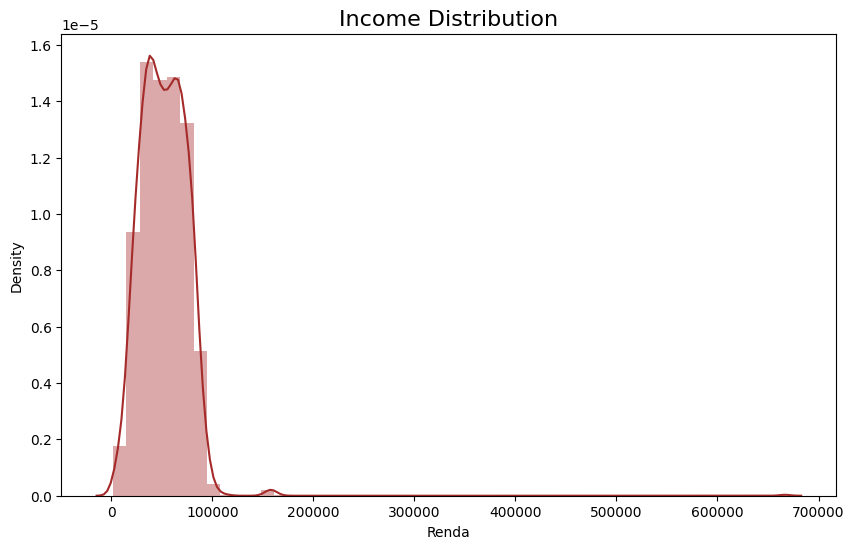

In [19]:
# Setting figure size
plt.figure(figsize = (10, 6)) 

# Creating the distribution plot
sns.distplot(df['Renda'], color = 'brown')  

# Setting the title
plt.title('Income Distribution', size = 16)  

# Displaying the plot
plt.show()

**Figure 3 - Income distribution (before treatment).**
Interpretation: Helps assess income skewness and dispersion before cleaning.

Outliers can be treated via removal, winsorization, or transformation. In this project, we opted for removal due to the low number of extreme records.

We removed outliers because they were few records and they reduce analysis robustness.

In [20]:
# Filter the dataframe and remove outliers
df = df[(df['Renda'] >= lower_bound) & (df['Renda'] <= upper_bound)]

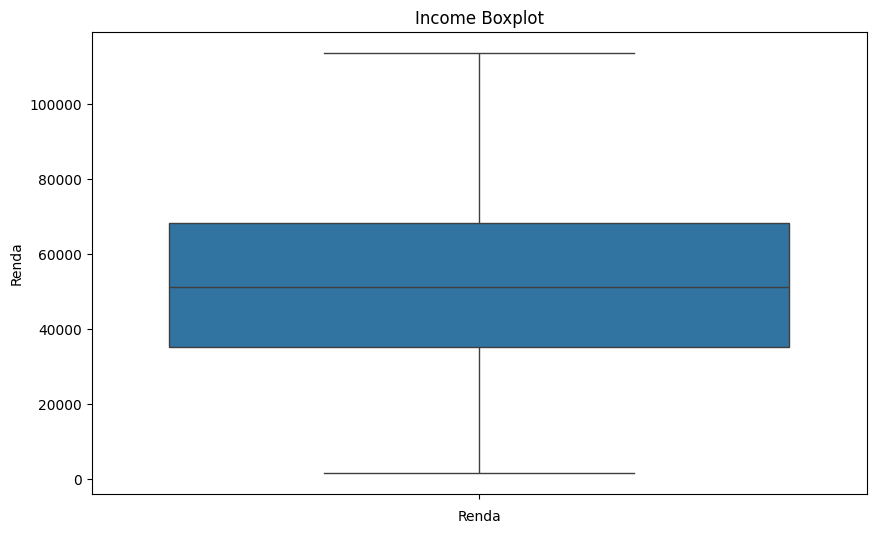

In [21]:
# Boxplot to identify outliers in the 'Renda' column
plt.figure(figsize = (10, 6))
sns.boxplot(df['Renda'])
plt.title('Income Boxplot')
plt.xlabel('Renda')
plt.show()

**Figure 4 - Income boxplot (after outlier removal).**
Interpretation: After treatment, the distribution is more stable for subsequent analyses.

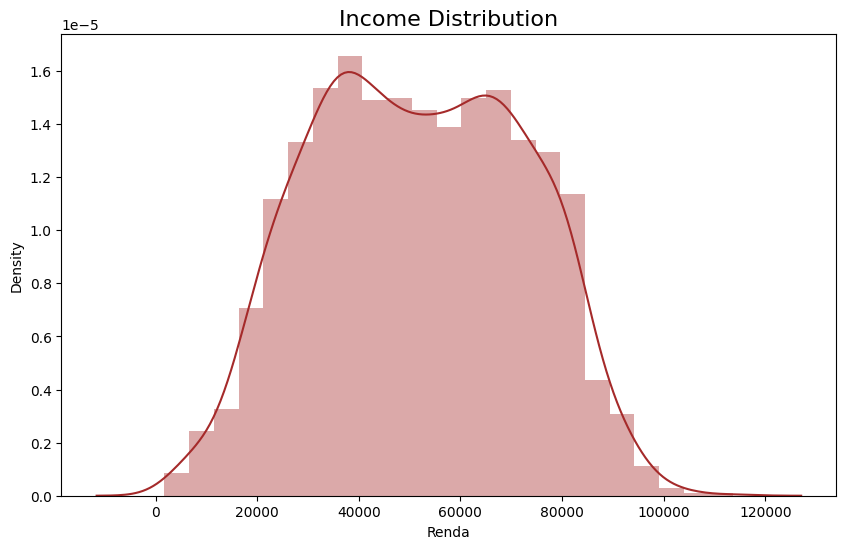

In [22]:
# Setting figure size
plt.figure(figsize = (10, 6)) 

# Creating the distribution plot
sns.distplot(df['Renda'], color = 'brown')  

# Setting the title
plt.title('Income Distribution', size = 16)  

# Displaying the plot
plt.show()

**Figure 5 - Income distribution (after treatment).**
Interpretation: Shows income behavior after outlier removal.

Missing-value treatment.

In [23]:
# Normalize data before applying KNNImputer (optional but recommended)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df[['Renda']])

In [24]:
# Create the KNNImputer
imputer = KNNImputer(n_neighbors=5)

In [25]:
# Impute missing values with the imputer
data_imputed = imputer.fit_transform(data_scaled)

In [26]:
# Converter de volta para o formato original 
df['Renda'] = scaler.inverse_transform(data_imputed)

In [27]:
print('Total de Valores Ausentes:', df.isnull().sum().sum())

Total de Valores Ausentes: 0


In [28]:
df.head()

,ID,Ano_Nascimento,Educacao,Estado_Civil,Renda,Criancas_Em_Casa,Adolescentes_Em_Casa,Data_Cadastro_Cliente,Gasto_Vinhos,Gasto_Frutas,...,Num_Compras_Web,Num_Compras_Catalogo,Num_Compras_Loja,Num_Visitas_Web_Mes,Aceitou_Campanha_1,Aceitou_Campanha_2,Aceitou_Campanha_3,Aceitou_Campanha_4,Aceitou_Campanha_5,Aceitou_Campanha_6
0,9970,1977,Graduação,Casado,55375.0,0,1,2013-10-17,42,11,...,1,1,6,2,0,0,0,0,0,0
1,4002,1960,PhD,Casado,77037.0,0,1,2013-10-13,463,96,...,7,7,12,3,0,0,0,0,0,0
2,10914,1970,Graduação,Solteiro,24163.0,1,1,2010-12-13,4,1,...,1,0,3,4,0,0,0,0,0,0
3,7279,1969,PhD,Casado,69476.0,0,0,2013-09-30,260,86,...,4,6,4,2,0,0,0,0,0,0
4,10582,1979,Graduação,Casado,72063.0,0,1,2007-03-13,180,32,...,5,2,12,2,0,0,0,0,0,0


## Exploratory Analysis and Feature Engineering

In [29]:
# Colunas
df.columns

Index(['ID', 'Ano_Nascimento', 'Educacao', 'Estado_Civil', 'Renda',
       'Criancas_Em_Casa', 'Adolescentes_Em_Casa', 'Data_Cadastro_Cliente',
       'Gasto_Vinhos', 'Gasto_Frutas', 'Gasto_Carnes', 'Gasto_Peixes',
       'Gasto_Doces', 'Gasto_Outros', 'Num_Compras_Promocionais',
       'Num_Compras_Web', 'Num_Compras_Catalogo', 'Num_Compras_Loja',
       'Num_Visitas_Web_Mes', 'Aceitou_Campanha_1', 'Aceitou_Campanha_2',
       'Aceitou_Campanha_3', 'Aceitou_Campanha_4', 'Aceitou_Campanha_5',
       'Aceitou_Campanha_6'],
      dtype='object')

In [30]:
# Drop categorical columns (in memory) to create boxplots of quantitative columns
data_boxplot = df.drop(columns = ['ID',
                                      'Educacao',
                                      'Estado_Civil',
                                      'Criancas_Em_Casa',
                                      'Data_Cadastro_Cliente',
                                      'Adolescentes_Em_Casa', 
                                      'Aceitou_Campanha_1', 
                                      'Aceitou_Campanha_2',
                                      'Aceitou_Campanha_3', 
                                      'Aceitou_Campanha_4', 
                                      'Aceitou_Campanha_5',
                                      'Aceitou_Campanha_6'])

In [31]:
data_boxplot.columns

Index(['Ano_Nascimento', 'Renda', 'Gasto_Vinhos', 'Gasto_Frutas',
       'Gasto_Carnes', 'Gasto_Peixes', 'Gasto_Doces', 'Gasto_Outros',
       'Num_Compras_Promocionais', 'Num_Compras_Web', 'Num_Compras_Catalogo',
       'Num_Compras_Loja', 'Num_Visitas_Web_Mes'],
      dtype='object')

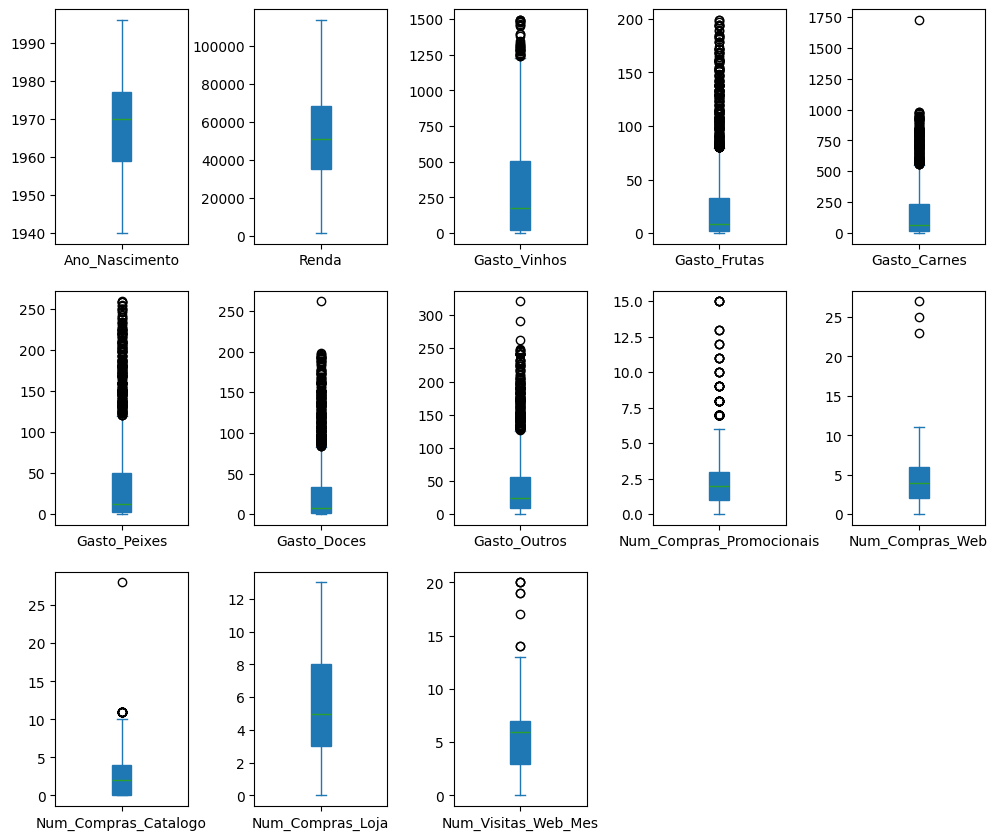

In [32]:
# Plot
data_boxplot.plot(subplots = True, layout = (4,5), kind = 'box', figsize = (12,14), patch_artist = True)
plt.subplots_adjust(wspace=0.5);

**Figure 6 - Boxplots of numeric variables.**
Interpretation: Compares dispersion and outliers across variables to identify areas of attention.

We performed feature engineering to support multivariate exploration.

In [33]:
# Create customer age column (current year - birth year)
ano_atual = datetime.now().year
df['Idade'] = ano_atual - df['Ano_Nascimento']

In [34]:
df.head()

,ID,Ano_Nascimento,Educacao,Estado_Civil,Renda,Criancas_Em_Casa,Adolescentes_Em_Casa,Data_Cadastro_Cliente,Gasto_Vinhos,Gasto_Frutas,...,Num_Compras_Catalogo,Num_Compras_Loja,Num_Visitas_Web_Mes,Aceitou_Campanha_1,Aceitou_Campanha_2,Aceitou_Campanha_3,Aceitou_Campanha_4,Aceitou_Campanha_5,Aceitou_Campanha_6,Idade
0,9970,1977,Graduação,Casado,55375.0,0,1,2013-10-17,42,11,...,1,6,2,0,0,0,0,0,0,49
1,4002,1960,PhD,Casado,77037.0,0,1,2013-10-13,463,96,...,7,12,3,0,0,0,0,0,0,66
2,10914,1970,Graduação,Solteiro,24163.0,1,1,2010-12-13,4,1,...,0,3,4,0,0,0,0,0,0,56
3,7279,1969,PhD,Casado,69476.0,0,0,2013-09-30,260,86,...,6,4,2,0,0,0,0,0,0,57
4,10582,1979,Graduação,Casado,72063.0,0,1,2007-03-13,180,32,...,2,12,2,0,0,0,0,0,0,47


In [35]:
# Create a column with the number of days as a customer since registration
df['Dias_Como_Cliente'] = df['Data_Cadastro_Cliente'].max() - df['Data_Cadastro_Cliente']

In [36]:
df.head()

,ID,Ano_Nascimento,Educacao,Estado_Civil,Renda,Criancas_Em_Casa,Adolescentes_Em_Casa,Data_Cadastro_Cliente,Gasto_Vinhos,Gasto_Frutas,...,Num_Compras_Loja,Num_Visitas_Web_Mes,Aceitou_Campanha_1,Aceitou_Campanha_2,Aceitou_Campanha_3,Aceitou_Campanha_4,Aceitou_Campanha_5,Aceitou_Campanha_6,Idade,Dias_Como_Cliente
0,9970,1977,Graduação,Casado,55375.0,0,1,2013-10-17,42,11,...,6,2,0,0,0,0,0,0,49,255 days
1,4002,1960,PhD,Casado,77037.0,0,1,2013-10-13,463,96,...,12,3,0,0,0,0,0,0,66,259 days
2,10914,1970,Graduação,Solteiro,24163.0,1,1,2010-12-13,4,1,...,3,4,0,0,0,0,0,0,56,1294 days
3,7279,1969,PhD,Casado,69476.0,0,0,2013-09-30,260,86,...,4,2,0,0,0,0,0,0,57,272 days
4,10582,1979,Graduação,Casado,72063.0,0,1,2007-03-13,180,32,...,12,2,0,0,0,0,0,0,47,2665 days


In [37]:
# Remove the word "days" from the end of each value in the Dias_Como_Cliente column
df['Dias_Como_Cliente'] = df['Dias_Como_Cliente'].astype(str).str.replace(' days', '')

In [38]:
df.head()

,ID,Ano_Nascimento,Educacao,Estado_Civil,Renda,Criancas_Em_Casa,Adolescentes_Em_Casa,Data_Cadastro_Cliente,Gasto_Vinhos,Gasto_Frutas,...,Num_Compras_Loja,Num_Visitas_Web_Mes,Aceitou_Campanha_1,Aceitou_Campanha_2,Aceitou_Campanha_3,Aceitou_Campanha_4,Aceitou_Campanha_5,Aceitou_Campanha_6,Idade,Dias_Como_Cliente
0,9970,1977,Graduação,Casado,55375.0,0,1,2013-10-17,42,11,...,6,2,0,0,0,0,0,0,49,255
1,4002,1960,PhD,Casado,77037.0,0,1,2013-10-13,463,96,...,12,3,0,0,0,0,0,0,66,259
2,10914,1970,Graduação,Solteiro,24163.0,1,1,2010-12-13,4,1,...,3,4,0,0,0,0,0,0,56,1294
3,7279,1969,PhD,Casado,69476.0,0,0,2013-09-30,260,86,...,4,2,0,0,0,0,0,0,57,272
4,10582,1979,Graduação,Casado,72063.0,0,1,2007-03-13,180,32,...,12,2,0,0,0,0,0,0,47,2665


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2205 entries, 0 to 2236
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   ID                        2205 non-null   int64         
 1   Ano_Nascimento            2205 non-null   int64         
 2   Educacao                  2205 non-null   object        
 3   Estado_Civil              2205 non-null   object        
 4   Renda                     2205 non-null   float64       
 5   Criancas_Em_Casa          2205 non-null   int64         
 6   Adolescentes_Em_Casa      2205 non-null   int64         
 7   Data_Cadastro_Cliente     2205 non-null   datetime64[ns]
 8   Gasto_Vinhos              2205 non-null   int64         
 9   Gasto_Frutas              2205 non-null   int64         
 10  Gasto_Carnes              2205 non-null   int64         
 11  Gasto_Peixes              2205 non-null   int64         
 12  Gasto_Doces              

In [40]:
# Adjust the data type of Dias_Como_Cliente
df['Dias_Como_Cliente'] = pd.to_numeric(df['Dias_Como_Cliente'], downcast = 'integer')

In [41]:
df.columns

Index(['ID', 'Ano_Nascimento', 'Educacao', 'Estado_Civil', 'Renda',
       'Criancas_Em_Casa', 'Adolescentes_Em_Casa', 'Data_Cadastro_Cliente',
       'Gasto_Vinhos', 'Gasto_Frutas', 'Gasto_Carnes', 'Gasto_Peixes',
       'Gasto_Doces', 'Gasto_Outros', 'Num_Compras_Promocionais',
       'Num_Compras_Web', 'Num_Compras_Catalogo', 'Num_Compras_Loja',
       'Num_Visitas_Web_Mes', 'Aceitou_Campanha_1', 'Aceitou_Campanha_2',
       'Aceitou_Campanha_3', 'Aceitou_Campanha_4', 'Aceitou_Campanha_5',
       'Aceitou_Campanha_6', 'Idade', 'Dias_Como_Cliente'],
      dtype='object')

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2205 entries, 0 to 2236
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   ID                        2205 non-null   int64         
 1   Ano_Nascimento            2205 non-null   int64         
 2   Educacao                  2205 non-null   object        
 3   Estado_Civil              2205 non-null   object        
 4   Renda                     2205 non-null   float64       
 5   Criancas_Em_Casa          2205 non-null   int64         
 6   Adolescentes_Em_Casa      2205 non-null   int64         
 7   Data_Cadastro_Cliente     2205 non-null   datetime64[ns]
 8   Gasto_Vinhos              2205 non-null   int64         
 9   Gasto_Frutas              2205 non-null   int64         
 10  Gasto_Carnes              2205 non-null   int64         
 11  Gasto_Peixes              2205 non-null   int64         
 12  Gasto_Doces              

In [43]:
# Create a variable with total purchases across the three channels
df['TotalCompras'] = df['Num_Compras_Web'] + df['Num_Compras_Catalogo'] + df['Num_Compras_Loja']

In [44]:
df.head()

,ID,Ano_Nascimento,Educacao,Estado_Civil,Renda,Criancas_Em_Casa,Adolescentes_Em_Casa,Data_Cadastro_Cliente,Gasto_Vinhos,Gasto_Frutas,...,Num_Visitas_Web_Mes,Aceitou_Campanha_1,Aceitou_Campanha_2,Aceitou_Campanha_3,Aceitou_Campanha_4,Aceitou_Campanha_5,Aceitou_Campanha_6,Idade,Dias_Como_Cliente,TotalCompras
0,9970,1977,Graduação,Casado,55375.0,0,1,2013-10-17,42,11,...,2,0,0,0,0,0,0,49,255,8
1,4002,1960,PhD,Casado,77037.0,0,1,2013-10-13,463,96,...,3,0,0,0,0,0,0,66,259,26
2,10914,1970,Graduação,Solteiro,24163.0,1,1,2010-12-13,4,1,...,4,0,0,0,0,0,0,56,1294,4
3,7279,1969,PhD,Casado,69476.0,0,0,2013-09-30,260,86,...,2,0,0,0,0,0,0,57,272,14
4,10582,1979,Graduação,Casado,72063.0,0,1,2007-03-13,180,32,...,2,0,0,0,0,0,0,47,2665,19


In [45]:
df.columns

Index(['ID', 'Ano_Nascimento', 'Educacao', 'Estado_Civil', 'Renda',
       'Criancas_Em_Casa', 'Adolescentes_Em_Casa', 'Data_Cadastro_Cliente',
       'Gasto_Vinhos', 'Gasto_Frutas', 'Gasto_Carnes', 'Gasto_Peixes',
       'Gasto_Doces', 'Gasto_Outros', 'Num_Compras_Promocionais',
       'Num_Compras_Web', 'Num_Compras_Catalogo', 'Num_Compras_Loja',
       'Num_Visitas_Web_Mes', 'Aceitou_Campanha_1', 'Aceitou_Campanha_2',
       'Aceitou_Campanha_3', 'Aceitou_Campanha_4', 'Aceitou_Campanha_5',
       'Aceitou_Campanha_6', 'Idade', 'Dias_Como_Cliente', 'TotalCompras'],
      dtype='object')

In [46]:
# Create Gasto_Total as the sum of all columns that start with Gasto
df['Gasto_Total'] = df.filter(like = 'Gasto').sum(axis=1)

In [47]:
df.head()

,ID,Ano_Nascimento,Educacao,Estado_Civil,Renda,Criancas_Em_Casa,Adolescentes_Em_Casa,Data_Cadastro_Cliente,Gasto_Vinhos,Gasto_Frutas,...,Aceitou_Campanha_1,Aceitou_Campanha_2,Aceitou_Campanha_3,Aceitou_Campanha_4,Aceitou_Campanha_5,Aceitou_Campanha_6,Idade,Dias_Como_Cliente,TotalCompras,Gasto_Total
0,9970,1977,Graduação,Casado,55375.0,0,1,2013-10-17,42,11,...,0,0,0,0,0,0,49,255,8,162
1,4002,1960,PhD,Casado,77037.0,0,1,2013-10-13,463,96,...,0,0,0,0,0,0,66,259,26,1123
2,10914,1970,Graduação,Solteiro,24163.0,1,1,2010-12-13,4,1,...,0,0,0,0,0,0,56,1294,4,17
3,7279,1969,PhD,Casado,69476.0,0,0,2013-09-30,260,86,...,0,0,0,0,0,0,57,272,14,1044
4,10582,1979,Graduação,Casado,72063.0,0,1,2007-03-13,180,32,...,0,0,0,0,0,0,47,2665,19,758


In [48]:
df.columns

Index(['ID', 'Ano_Nascimento', 'Educacao', 'Estado_Civil', 'Renda',
       'Criancas_Em_Casa', 'Adolescentes_Em_Casa', 'Data_Cadastro_Cliente',
       'Gasto_Vinhos', 'Gasto_Frutas', 'Gasto_Carnes', 'Gasto_Peixes',
       'Gasto_Doces', 'Gasto_Outros', 'Num_Compras_Promocionais',
       'Num_Compras_Web', 'Num_Compras_Catalogo', 'Num_Compras_Loja',
       'Num_Visitas_Web_Mes', 'Aceitou_Campanha_1', 'Aceitou_Campanha_2',
       'Aceitou_Campanha_3', 'Aceitou_Campanha_4', 'Aceitou_Campanha_5',
       'Aceitou_Campanha_6', 'Idade', 'Dias_Como_Cliente', 'TotalCompras',
       'Gasto_Total'],
      dtype='object')

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2205 entries, 0 to 2236
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   ID                        2205 non-null   int64         
 1   Ano_Nascimento            2205 non-null   int64         
 2   Educacao                  2205 non-null   object        
 3   Estado_Civil              2205 non-null   object        
 4   Renda                     2205 non-null   float64       
 5   Criancas_Em_Casa          2205 non-null   int64         
 6   Adolescentes_Em_Casa      2205 non-null   int64         
 7   Data_Cadastro_Cliente     2205 non-null   datetime64[ns]
 8   Gasto_Vinhos              2205 non-null   int64         
 9   Gasto_Frutas              2205 non-null   int64         
 10  Gasto_Carnes              2205 non-null   int64         
 11  Gasto_Peixes              2205 non-null   int64         
 12  Gasto_Doces              

In [50]:
df['Aceitou_Campanha_1'].value_counts()

Aceitou_Campanha_1
0    2042
1     163
Name: count, dtype: int64

In [51]:
df['Aceitou_Campanha_2'].value_counts()

Aceitou_Campanha_2
0    2041
1     164
Name: count, dtype: int64

In [52]:
# Create a variable indicating whether the customer accepted any campaign
campaign_cols = [c for c in df.columns if c.startswith('Aceitou_Campanha_')]
df['aceite_campanha'] = df[campaign_cols].sum(axis=1)

In [53]:
df.head()

,ID,Ano_Nascimento,Educacao,Estado_Civil,Renda,Criancas_Em_Casa,Adolescentes_Em_Casa,Data_Cadastro_Cliente,Gasto_Vinhos,Gasto_Frutas,...,Aceitou_Campanha_2,Aceitou_Campanha_3,Aceitou_Campanha_4,Aceitou_Campanha_5,Aceitou_Campanha_6,Idade,Dias_Como_Cliente,TotalCompras,Gasto_Total,aceite_campanha
0,9970,1977,Graduação,Casado,55375.0,0,1,2013-10-17,42,11,...,0,0,0,0,0,49,255,8,162,0
1,4002,1960,PhD,Casado,77037.0,0,1,2013-10-13,463,96,...,0,0,0,0,0,66,259,26,1123,0
2,10914,1970,Graduação,Solteiro,24163.0,1,1,2010-12-13,4,1,...,0,0,0,0,0,56,1294,4,17,0
3,7279,1969,PhD,Casado,69476.0,0,0,2013-09-30,260,86,...,0,0,0,0,0,57,272,14,1044,0
4,10582,1979,Graduação,Casado,72063.0,0,1,2007-03-13,180,32,...,0,0,0,0,0,47,2665,19,758,0


In [54]:
df.sample(10)

,ID,Ano_Nascimento,Educacao,Estado_Civil,Renda,Criancas_Em_Casa,Adolescentes_Em_Casa,Data_Cadastro_Cliente,Gasto_Vinhos,Gasto_Frutas,...,Aceitou_Campanha_2,Aceitou_Campanha_3,Aceitou_Campanha_4,Aceitou_Campanha_5,Aceitou_Campanha_6,Idade,Dias_Como_Cliente,TotalCompras,Gasto_Total,aceite_campanha
1462,7409,1970,Graduação,Casado,53187.0,1,0,2013-10-26,211,2,...,0,0,0,0,0,56,246,11,267,0
1112,11039,1975,Graduação,Casado,51948.0,0,1,2013-09-17,82,33,...,0,0,0,0,0,51,285,11,311,0
56,10476,1958,Graduação,Casado,67267.0,0,1,2014-05-13,134,11,...,0,0,0,0,0,68,47,10,251,0
2187,1743,1974,Graduação,Solteiro,69719.0,0,0,2014-05-26,273,86,...,0,0,0,0,0,52,34,10,801,0
1667,4066,1978,Ensino Médio,Divorciado,21282.0,1,0,2005-11-14,1,5,...,0,0,0,0,0,48,3149,5,46,0
1758,5223,1966,Mestrado,Casado,45903.0,0,1,2014-04-23,33,8,...,0,0,0,0,0,60,67,6,66,0
1312,4518,1979,Graduação,Casado,85693.0,0,1,2013-04-20,386,172,...,0,0,0,0,0,47,435,25,1169,0
1434,3254,1971,Graduação,Casado,70886.0,1,0,2013-10-14,407,70,...,0,0,0,0,0,55,258,13,960,0
276,2677,1956,Graduação,Casado,46097.0,0,1,2013-03-31,72,24,...,0,0,0,0,0,70,455,10,241,0
2052,2875,1978,Graduação,Casado,67023.0,0,0,2003-04-14,444,44,...,0,0,0,0,0,48,4094,23,906,0


In [55]:
# Type adjustment and new column creation
df['RespostaCampanha'] = df['aceite_campanha'].apply(lambda x: 'Accepted' if x > 0 else 'Not Accepted')

In [56]:
df.head()

,ID,Ano_Nascimento,Educacao,Estado_Civil,Renda,Criancas_Em_Casa,Adolescentes_Em_Casa,Data_Cadastro_Cliente,Gasto_Vinhos,Gasto_Frutas,...,Aceitou_Campanha_3,Aceitou_Campanha_4,Aceitou_Campanha_5,Aceitou_Campanha_6,Idade,Dias_Como_Cliente,TotalCompras,Gasto_Total,aceite_campanha,RespostaCampanha
0,9970,1977,Graduação,Casado,55375.0,0,1,2013-10-17,42,11,...,0,0,0,0,49,255,8,162,0,Not Accepted
1,4002,1960,PhD,Casado,77037.0,0,1,2013-10-13,463,96,...,0,0,0,0,66,259,26,1123,0,Not Accepted
2,10914,1970,Graduação,Solteiro,24163.0,1,1,2010-12-13,4,1,...,0,0,0,0,56,1294,4,17,0,Not Accepted
3,7279,1969,PhD,Casado,69476.0,0,0,2013-09-30,260,86,...,0,0,0,0,57,272,14,1044,0,Not Accepted
4,10582,1979,Graduação,Casado,72063.0,0,1,2007-03-13,180,32,...,0,0,0,0,47,2665,19,758,0,Not Accepted


In [57]:
df.sample(10)

,ID,Ano_Nascimento,Educacao,Estado_Civil,Renda,Criancas_Em_Casa,Adolescentes_Em_Casa,Data_Cadastro_Cliente,Gasto_Vinhos,Gasto_Frutas,...,Aceitou_Campanha_3,Aceitou_Campanha_4,Aceitou_Campanha_5,Aceitou_Campanha_6,Idade,Dias_Como_Cliente,TotalCompras,Gasto_Total,aceite_campanha,RespostaCampanha
865,905,1986,Graduação,Divorciado,21846.0,1,0,2013-10-22,7,17,...,0,0,0,0,40,250,7,84,0,Not Accepted
1992,4990,1954,Graduação,Casado,59111.0,0,0,2005-02-13,524,0,...,0,0,0,0,72,3423,20,869,0,Not Accepted
637,8486,1971,Mestrado,Casado,30538.0,1,0,2010-01-12,284,0,...,0,0,0,0,55,1629,13,367,0,Not Accepted
1086,8659,1952,PhD,Casado,69805.0,0,1,2014-01-21,750,71,...,0,0,0,0,74,159,25,1038,0,Not Accepted
1921,4279,1963,Ensino Médio,Solteiro,39548.0,1,1,2014-03-31,15,4,...,0,0,0,0,63,90,5,54,0,Not Accepted
1732,6202,1960,Graduação,Casado,63381.0,0,1,2010-05-12,571,50,...,0,0,0,0,66,1509,22,1005,0,Not Accepted
1639,7514,1956,Ensino Médio,Casado,54342.0,1,1,2007-03-13,84,10,...,0,0,0,0,70,2665,8,177,0,Not Accepted
1048,7966,1959,Graduação,Solteiro,80982.0,1,1,2001-08-13,505,137,...,0,0,0,0,67,4703,27,1191,0,Not Accepted
98,3112,1977,Mestrado,Casado,22701.0,1,0,2009-05-13,2,4,...,0,0,0,0,49,1873,4,24,0,Not Accepted
2067,7476,1964,Mestrado,Solteiro,63972.0,0,1,2012-02-12,928,63,...,0,0,0,0,62,868,19,1269,1,Accepted


In [58]:
# Sample of created variables for validation
df[['Idade', 'Dias_Como_Cliente', 'TotalCompras', 'Gasto_Total', 'RespostaCampanha']].sample(10)

,Idade,Dias_Como_Cliente,TotalCompras,Gasto_Total,RespostaCampanha
2058,62,1720,17,546,Accepted
473,59,1205,10,253,Not Accepted
845,55,867,3,28,Not Accepted
718,63,523,21,825,Not Accepted
932,61,3637,19,1363,Accepted
88,70,62,16,1588,Accepted
2151,62,2755,24,1049,Not Accepted
401,52,381,11,368,Not Accepted
2157,59,492,32,1529,Accepted
51,52,104,15,446,Accepted


In [59]:
# These variables are no longer needed
df.drop(['Ano_Nascimento', 'Data_Cadastro_Cliente', 'aceite_campanha'], axis = 1, inplace = True)

In [60]:
df.head()

,ID,Educacao,Estado_Civil,Renda,Criancas_Em_Casa,Adolescentes_Em_Casa,Gasto_Vinhos,Gasto_Frutas,Gasto_Carnes,Gasto_Peixes,...,Aceitou_Campanha_2,Aceitou_Campanha_3,Aceitou_Campanha_4,Aceitou_Campanha_5,Aceitou_Campanha_6,Idade,Dias_Como_Cliente,TotalCompras,Gasto_Total,RespostaCampanha
0,9970,Graduação,Casado,55375.0,0,1,42,11,57,10,...,0,0,0,0,0,49,255,8,162,Not Accepted
1,4002,PhD,Casado,77037.0,0,1,463,96,333,168,...,0,0,0,0,0,66,259,26,1123,Not Accepted
2,10914,Graduação,Solteiro,24163.0,1,1,4,1,7,2,...,0,0,0,0,0,56,1294,4,17,Not Accepted
3,7279,PhD,Casado,69476.0,0,0,260,86,559,63,...,0,0,0,0,0,57,272,14,1044,Not Accepted
4,10582,Graduação,Casado,72063.0,0,1,180,32,348,76,...,0,0,0,0,0,47,2665,19,758,Not Accepted


In [61]:
df.describe()

,ID,Renda,Criancas_Em_Casa,Adolescentes_Em_Casa,Gasto_Vinhos,Gasto_Frutas,Gasto_Carnes,Gasto_Peixes,Gasto_Doces,Gasto_Outros,...,Aceitou_Campanha_1,Aceitou_Campanha_2,Aceitou_Campanha_3,Aceitou_Campanha_4,Aceitou_Campanha_5,Aceitou_Campanha_6,Idade,Dias_Como_Cliente,TotalCompras,Gasto_Total
count,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,...,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.00000,2205.000000,2205.000000,2205.000000,2205.000000
mean,5585.439456,51622.094785,0.442177,0.506576,306.164626,26.403175,165.312018,37.756463,27.128345,44.057143,...,0.073923,0.074376,0.073016,0.064399,0.013605,0.15102,57.095692,1307.092971,12.569615,606.821769
std,3247.546423,20713.063826,0.537132,0.544380,337.493839,39.784484,217.784507,54.824635,41.130468,51.736211,...,0.261705,0.262442,0.260222,0.245518,0.115872,0.35815,11.705801,1429.824606,7.180350,601.675284
min,0.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,30.000000,0.000000,0.000000,5.000000
25%,2815.000000,35196.000000,0.000000,0.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,49.000000,286.000000,6.000000,69.000000
50%,5455.000000,51287.000000,0.000000,0.000000,178.000000,8.000000,68.000000,12.000000,8.000000,25.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,56.000000,583.000000,12.000000,397.000000
75%,8418.000000,68281.000000,1.000000,1.000000,507.000000,33.000000,232.000000,50.000000,34.000000,56.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,67.000000,2116.000000,18.000000,1047.000000
max,11191.000000,113734.000000,2.000000,2.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,86.000000,4915.000000,32.000000,2525.000000


## Multivariate Insights

The analyses below answer relevant business questions.

### Variable Distributions

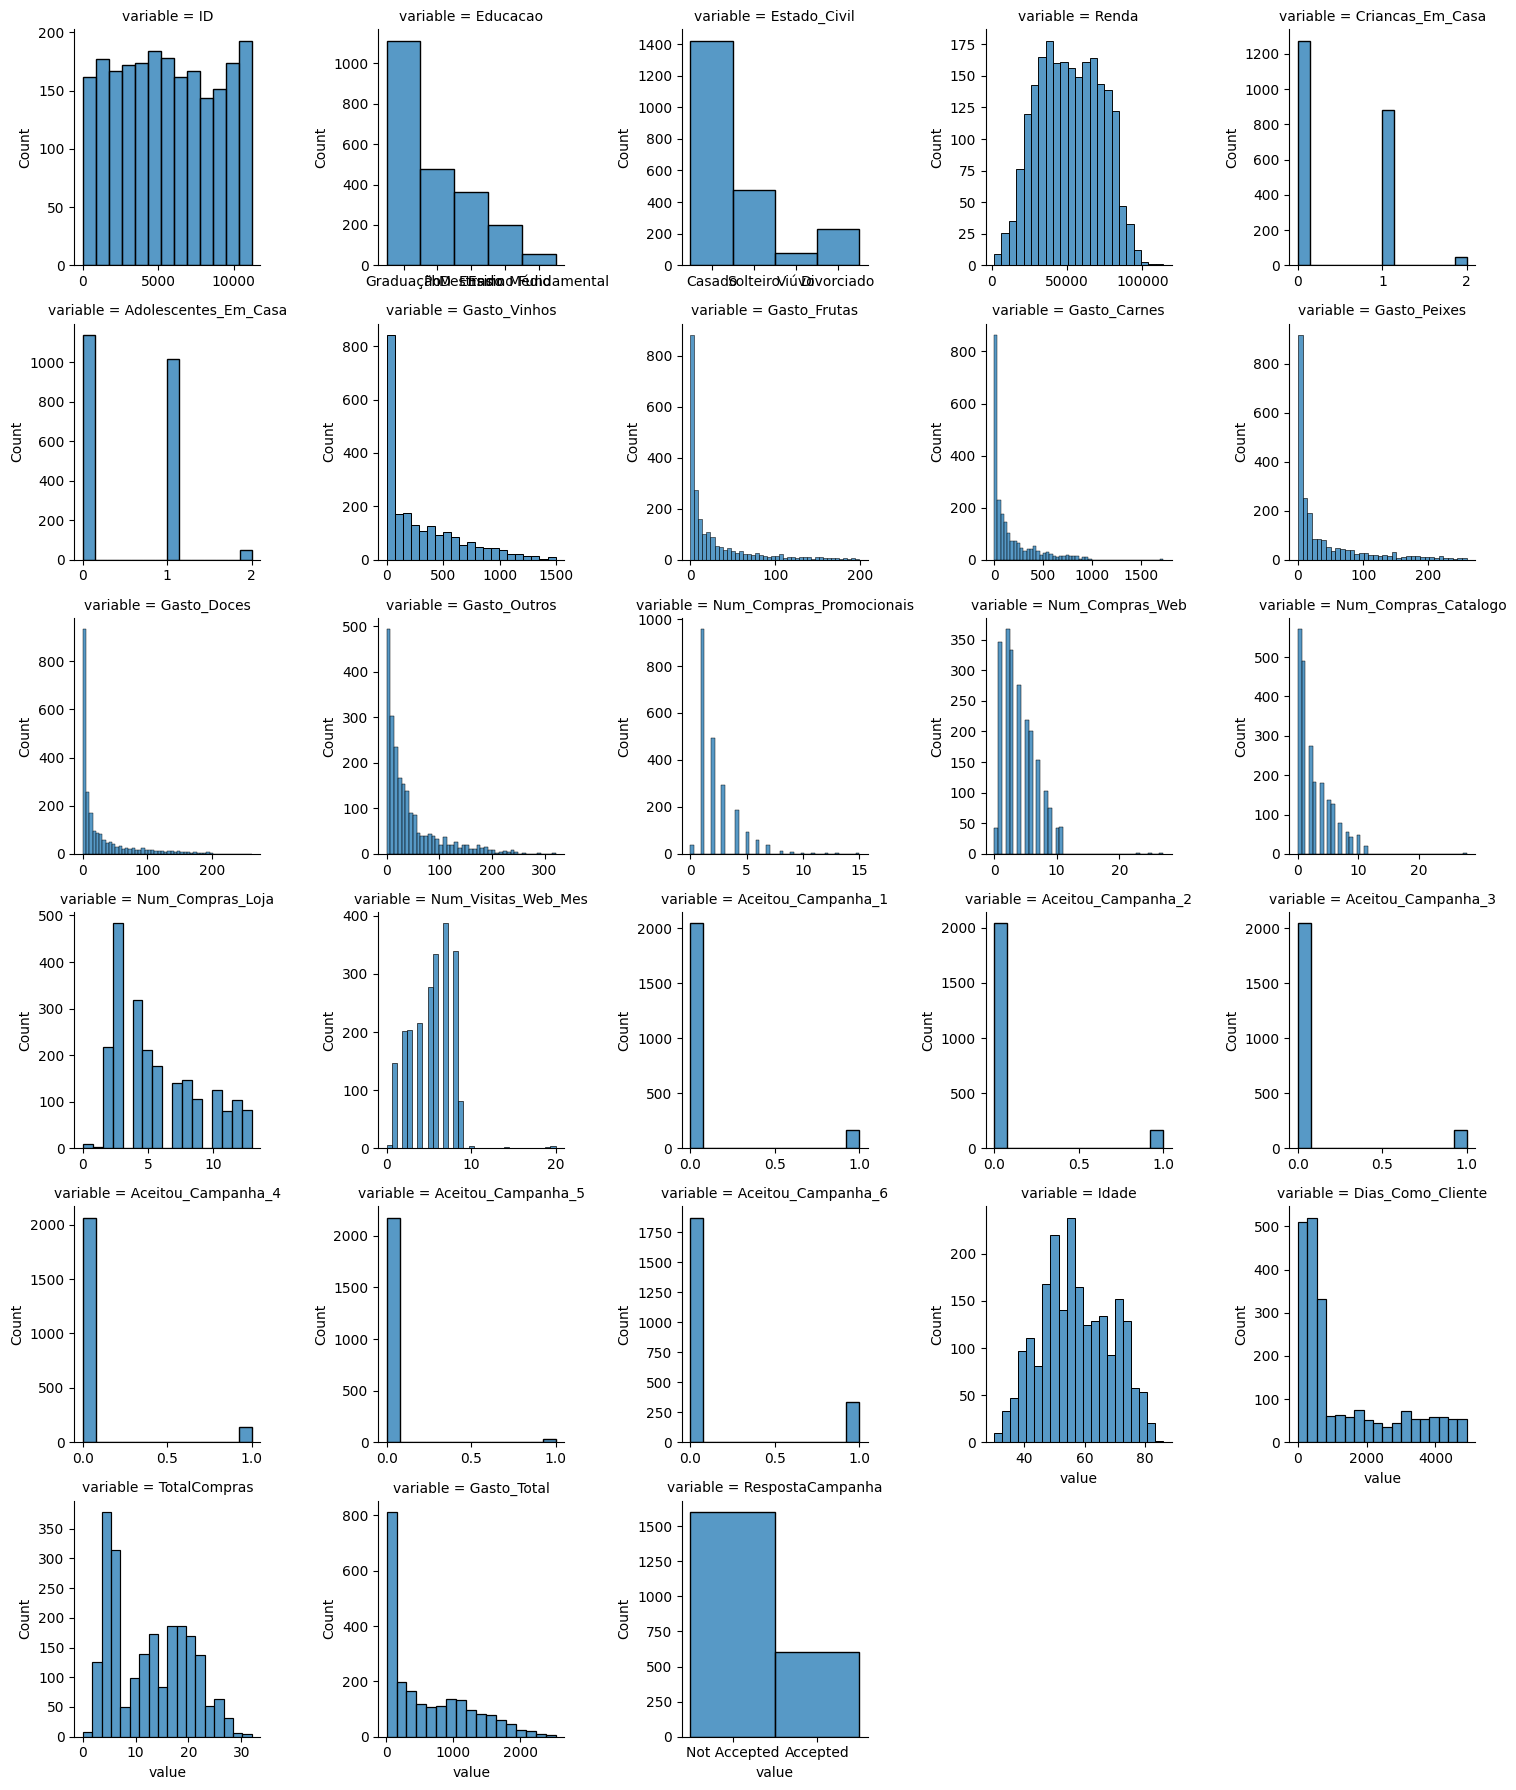

In [62]:
# Variable distribution
hist = pd.melt(df, value_vars = df )
hist = sns.FacetGrid (hist, col = 'variable', col_wrap = 5, sharex = False, sharey = False)
hist.map(sns.histplot, 'value')

**Figure 7 - Distribution of variables.**
Interpretation: Compares scale and distribution shapes across numeric variables.

### Campaign Acceptance Proportion

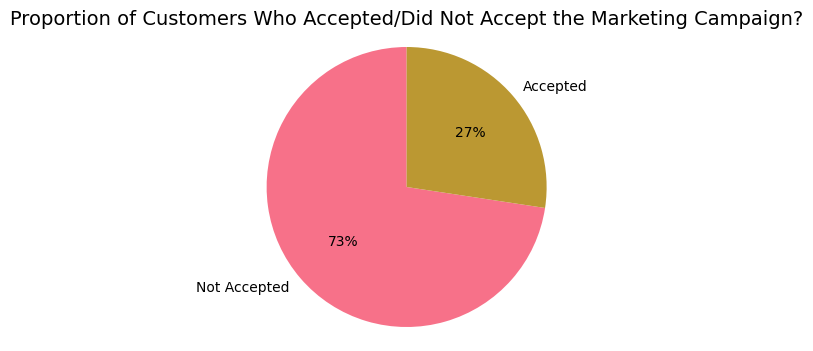

In [63]:
# Plot

# Figure size
fig, ax = plt.subplots(figsize = (6, 4))

# Count occurrences of each response
counts = df['RespostaCampanha'].value_counts()
labels = counts.index.tolist()

# Paleta de cores
colors = sns.color_palette('husl')

# Pie chart
ax.pie(counts, labels = labels, colors = colors, autopct = '%.0f%%', startangle = 90)

# Title
ax.set_title('Proportion of Customers Who Accepted/Did Not Accept the Marketing Campaign?', fontsize = 14)

# Keep axes equal
ax.axis('equal')

# Display 
plt.show()

**Figure 8 - Campaign response proportion.**
Interpretation: Shows the balance between customers who accepted and did not accept the campaign.

### Success Rate by Campaign

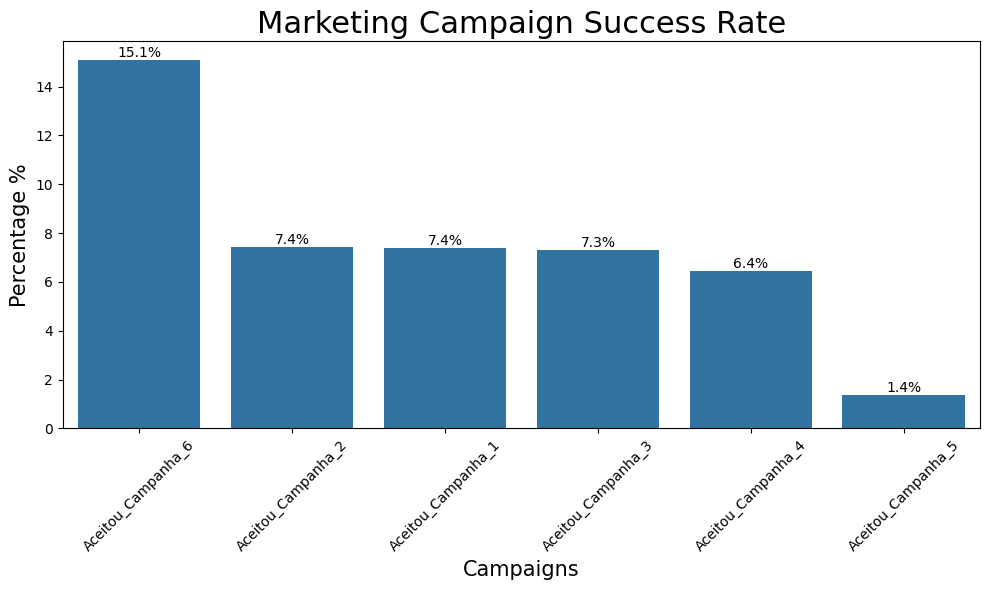

In [64]:
# Campaign list
Campaigns = ['Aceitou_Campanha_1', 
             'Aceitou_Campanha_2', 
             'Aceitou_Campanha_3', 
             'Aceitou_Campanha_4', 
             'Aceitou_Campanha_5', 
             'Aceitou_Campanha_6']

# Compute the percentage
campaigns = pd.DataFrame(df[Campaigns].mean() * 100, columns = ['Percent']).reset_index()

# Plot
plt.figure(figsize = (10, 6))
ax = sns.barplot(x = 'index', y = 'Percent', data = campaigns.sort_values('Percent', ascending = False))

# Labels
plt.xlabel('Campaigns', size=15)
plt.ylabel('Percentage %', size=15)
plt.title('Marketing Campaign Success Rate', size = 22)

# Add percentage labels to the chart
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', 
                (p.get_x() + p.get_width() / 2, 
                 p.get_height()), 
                ha = 'center', 
                va = 'bottom')

# Rotate x-axis labels
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)

# Display 
plt.tight_layout() # Make the plot fit exactly the screen size
plt.show()

**Figure 9 - Success rate by campaign.**
Interpretation: Compares relative campaign performance and indicates investment priorities.

### Relationship Between Age and Spending

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2205 entries, 0 to 2236
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        2205 non-null   int64  
 1   Educacao                  2205 non-null   object 
 2   Estado_Civil              2205 non-null   object 
 3   Renda                     2205 non-null   float64
 4   Criancas_Em_Casa          2205 non-null   int64  
 5   Adolescentes_Em_Casa      2205 non-null   int64  
 6   Gasto_Vinhos              2205 non-null   int64  
 7   Gasto_Frutas              2205 non-null   int64  
 8   Gasto_Carnes              2205 non-null   int64  
 9   Gasto_Peixes              2205 non-null   int64  
 10  Gasto_Doces               2205 non-null   int64  
 11  Gasto_Outros              2205 non-null   int64  
 12  Num_Compras_Promocionais  2205 non-null   int64  
 13  Num_Compras_Web           2205 non-null   int64  
 14  Num_Compras_C

In [66]:
# Filter categorical columns and compute correlation for quantitative columns
df_corr = df.drop(['ID',
                           'Educacao',
                           'Estado_Civil',
                           'Criancas_Em_Casa',
                           'Adolescentes_Em_Casa', 
                           'Aceitou_Campanha_1', 
                           'Aceitou_Campanha_2',
                           'Aceitou_Campanha_3', 
                           'Aceitou_Campanha_4', 
                           'Aceitou_Campanha_5',
                           'Aceitou_Campanha_6', 
                           'Educacao',
                           'RespostaCampanha'], axis = 1).corr()

In [67]:
column_corr = df_corr.loc['Idade']

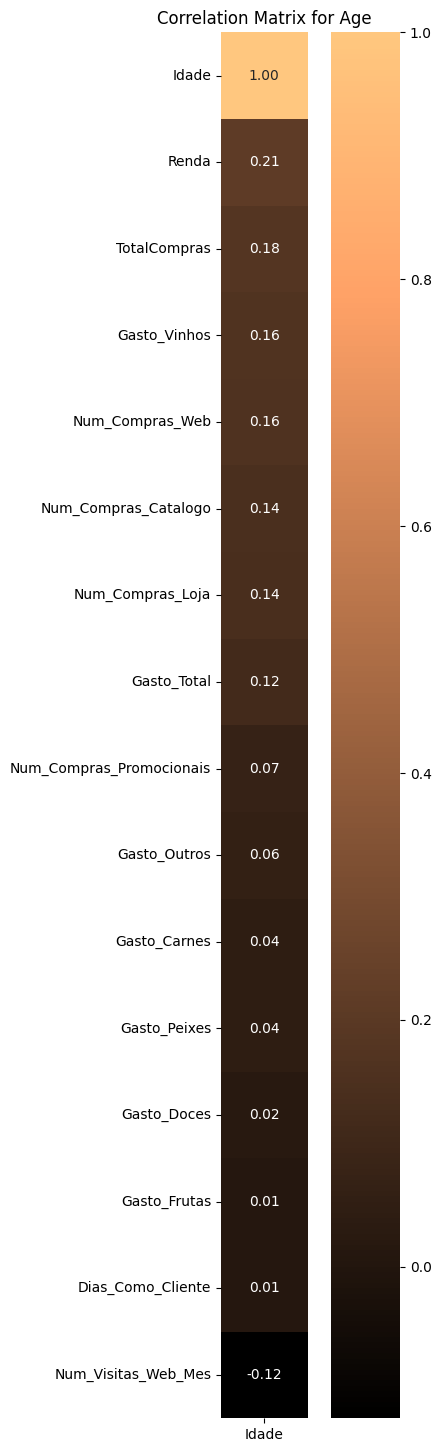

In [68]:
# Plot
plt.figure(figsize = (6, 18))
sns.heatmap(pd.DataFrame(column_corr.sort_values(ascending = False)), 
            annot = True, 
            cmap = 'copper', 
            cbar = True,
            square = True,
            fmt = '.2f')
plt.title('Correlation Matrix for Age')
plt.show()

**Figure 10 - Correlation between age and spending variables.**
Interpretation: Indicates which spending variables are most associated with age.

### Total Spend vs. Campaign Response

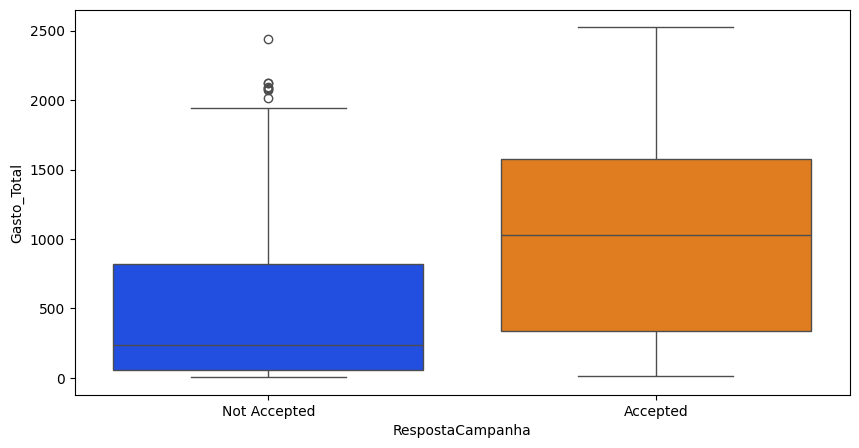

In [69]:
# Plot
plt.figure(figsize = (10,5))
sns.boxplot(x = 'RespostaCampanha', y = 'Gasto_Total', data = df, palette = 'bright');

**Figure 11 - Total spend by campaign response.**
Interpretation: Differences between groups suggest an association between total spend and acceptance.

### Categories With Highest Spend

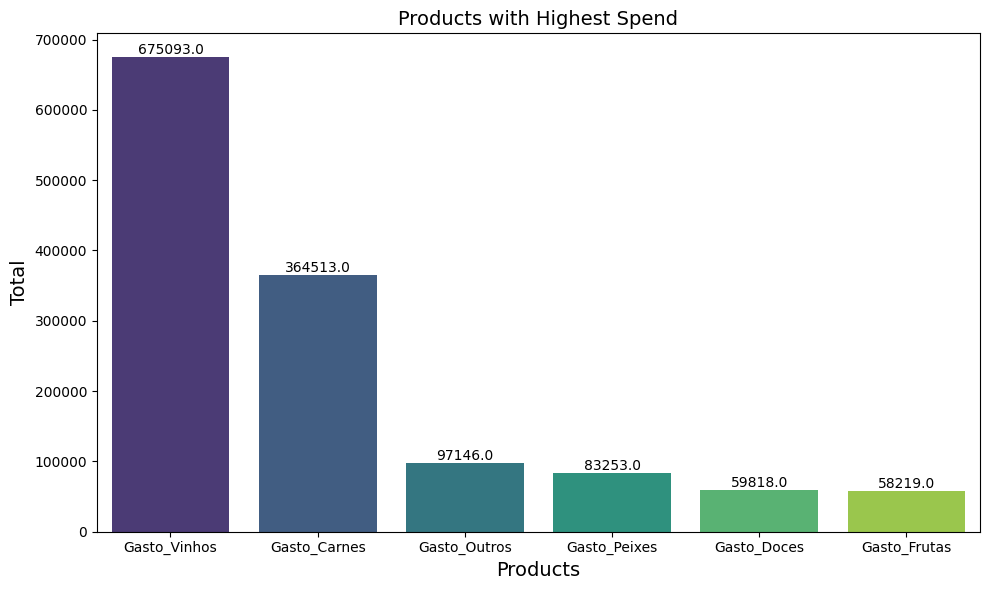

In [70]:
# Product categories
products = ['Gasto_Vinhos', 
            'Gasto_Frutas',
            'Gasto_Carnes', 
            'Gasto_Peixes',
            'Gasto_Doces',
            'Gasto_Outros']

# Create a dataframe with totals
df_products = pd.DataFrame(df[products].sum(), columns = ['Sum']).reset_index()

# Plot
plt.figure(figsize = (10, 6))
ax = sns.barplot(x = 'index', 
                 y = 'Sum', 
                 data = df_products.sort_values('Sum', ascending = False), 
                 palette = 'viridis')

# Labels
plt.xlabel('Products', size = 14)
plt.ylabel('Total', size = 14)
plt.title('Products with Highest Spend', size = 14)

# Add values to the chart
for p in ax.patches:
    ax.annotate(p.get_height(), (p.get_x() + p.get_width() / 2, p.get_height()), ha = 'center', va = 'bottom')

# Display 
plt.tight_layout()
plt.show()

**Figure 12 - Categories with highest total spend.**
Interpretation: Identifies categories with the highest contribution to total spending.

### Wine Spend vs. Response

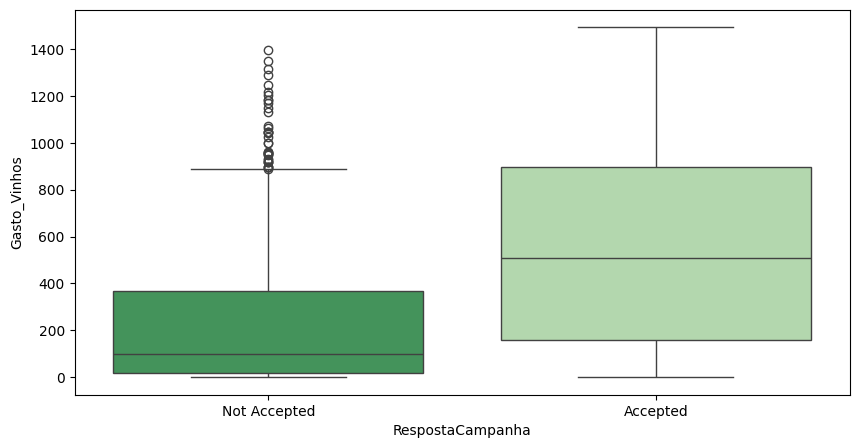

In [71]:
plt.figure(figsize = (10,5))
sns.boxplot(x = 'RespostaCampanha', y = 'Gasto_Vinhos', data = df, palette = 'Greens_r');

**Figure 13 - Wine spend by campaign response.**
Interpretation: Compares wine spend between responders and non-responders.

### Income vs. Response

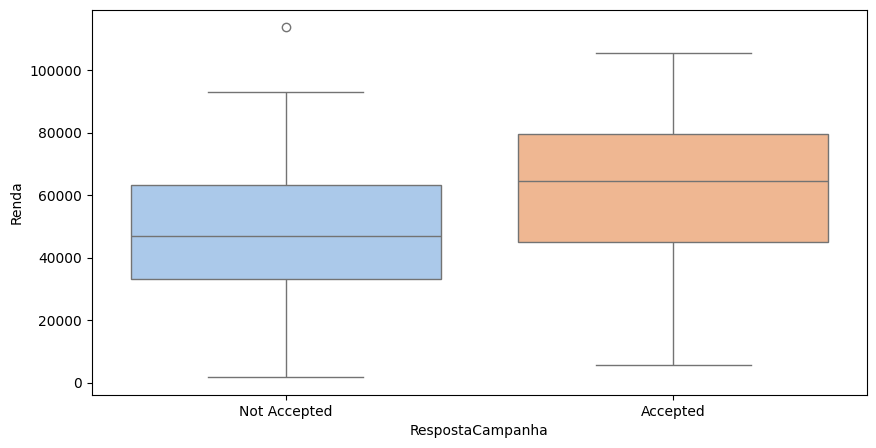

In [72]:
# Plot
plt.figure(figsize = (10,5))
sns.boxplot(x = 'RespostaCampanha', y = 'Renda', data = df, palette = 'pastel');

**Figure 14 - Income by campaign response.**
Interpretation: Compares income distributions between response groups.

### Income vs. Total Spend

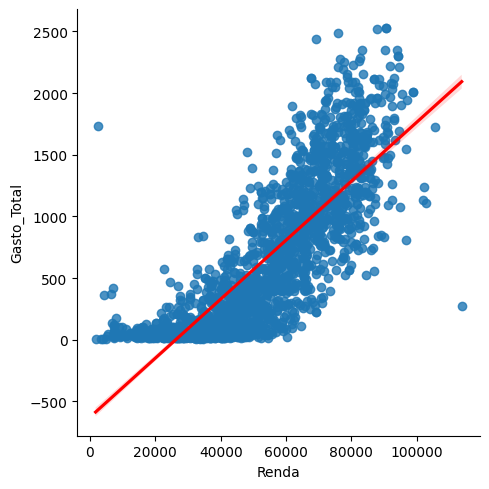

In [73]:
# Plot
sns.lmplot(x = 'Renda', y = 'Gasto_Total', data = df, palette = 'blue', line_kws = {'color': 'red'})

**Figure 15 - Income vs. total spend.**
Interpretation: Assesses the direction and strength of the relationship between income and total spend.

### Feature Importance (Model)

In [74]:
df.head()

,ID,Educacao,Estado_Civil,Renda,Criancas_Em_Casa,Adolescentes_Em_Casa,Gasto_Vinhos,Gasto_Frutas,Gasto_Carnes,Gasto_Peixes,...,Aceitou_Campanha_2,Aceitou_Campanha_3,Aceitou_Campanha_4,Aceitou_Campanha_5,Aceitou_Campanha_6,Idade,Dias_Como_Cliente,TotalCompras,Gasto_Total,RespostaCampanha
0,9970,Graduação,Casado,55375.0,0,1,42,11,57,10,...,0,0,0,0,0,49,255,8,162,Not Accepted
1,4002,PhD,Casado,77037.0,0,1,463,96,333,168,...,0,0,0,0,0,66,259,26,1123,Not Accepted
2,10914,Graduação,Solteiro,24163.0,1,1,4,1,7,2,...,0,0,0,0,0,56,1294,4,17,Not Accepted
3,7279,PhD,Casado,69476.0,0,0,260,86,559,63,...,0,0,0,0,0,57,272,14,1044,Not Accepted
4,10582,Graduação,Casado,72063.0,0,1,180,32,348,76,...,0,0,0,0,0,47,2665,19,758,Not Accepted


In [75]:
# Convert text variables to numeric representation using one-hot encoding
df_imp = pd.get_dummies(df, columns = ['Educacao', 'Estado_Civil'])

In [76]:
df_imp.columns

Index(['ID', 'Renda', 'Criancas_Em_Casa', 'Adolescentes_Em_Casa',
       'Gasto_Vinhos', 'Gasto_Frutas', 'Gasto_Carnes', 'Gasto_Peixes',
       'Gasto_Doces', 'Gasto_Outros', 'Num_Compras_Promocionais',
       'Num_Compras_Web', 'Num_Compras_Catalogo', 'Num_Compras_Loja',
       'Num_Visitas_Web_Mes', 'Aceitou_Campanha_1', 'Aceitou_Campanha_2',
       'Aceitou_Campanha_3', 'Aceitou_Campanha_4', 'Aceitou_Campanha_5',
       'Aceitou_Campanha_6', 'Idade', 'Dias_Como_Cliente', 'TotalCompras',
       'Gasto_Total', 'RespostaCampanha', 'Educacao_Ensino Fundamental',
       'Educacao_Ensino Médio', 'Educacao_Graduação', 'Educacao_Mestrado',
       'Educacao_PhD', 'Estado_Civil_Casado', 'Estado_Civil_Divorciado',
       'Estado_Civil_Solteiro', 'Estado_Civil_Viúvo'],
      dtype='object')

In [77]:
df_imp.head()

,ID,Renda,Criancas_Em_Casa,Adolescentes_Em_Casa,Gasto_Vinhos,Gasto_Frutas,Gasto_Carnes,Gasto_Peixes,Gasto_Doces,Gasto_Outros,...,RespostaCampanha,Educacao_Ensino Fundamental,Educacao_Ensino Médio,Educacao_Graduação,Educacao_Mestrado,Educacao_PhD,Estado_Civil_Casado,Estado_Civil_Divorciado,Estado_Civil_Solteiro,Estado_Civil_Viúvo
0,9970,55375.0,0,1,42,11,57,10,28,14,...,Not Accepted,False,False,True,False,False,True,False,False,False
1,4002,77037.0,0,1,463,96,333,168,53,10,...,Not Accepted,False,False,False,False,True,True,False,False,False
2,10914,24163.0,1,1,4,1,7,2,1,2,...,Not Accepted,False,False,True,False,False,False,False,True,False
3,7279,69476.0,0,0,260,86,559,63,9,67,...,Not Accepted,False,False,False,False,True,True,False,False,False
4,10582,72063.0,0,1,180,32,348,76,32,90,...,Not Accepted,False,False,True,False,False,True,False,False,False


In [78]:
# Remove redundant or unnecessary variables
# Since we are creating X (input data), we remove RespostaCampanha (output data)
X = df_imp.drop(['ID',
                     'Gasto_Vinhos', 
                     'Gasto_Frutas', 
                     'Gasto_Carnes', 
                     'Gasto_Peixes',
                     'Gasto_Doces', 
                     'Gasto_Outros',
                     'Num_Compras_Web', 
                     'Num_Compras_Catalogo', 
                     'Num_Compras_Loja',
                     'Aceitou_Campanha_1', 
                     'Aceitou_Campanha_2', 
                     'Aceitou_Campanha_3', 
                     'Aceitou_Campanha_4', 
                     'Aceitou_Campanha_5', 
                     'Aceitou_Campanha_6',
                     'RespostaCampanha'], axis = 1)

In [79]:
# Convert variable to numeric representation
y = df_imp['RespostaCampanha'].map({'Not Accepted': 0, 'Accepted': 1})

In [80]:
# Create the model
modelo_rf = RandomForestClassifier(random_state = 43)      

In [81]:
# Treina o modelo
modelo_dsa = modelo_rf.fit(X,y)

In [82]:
# Extract feature importance for each variable
importances = modelo_dsa.feature_importances_

In [83]:
# Standard deviation of feature importances
std = np.std([tree.feature_importances_ for tree in modelo_dsa.estimators_], axis = 0)

In [84]:
# Indices
indices = np.argsort(importances)

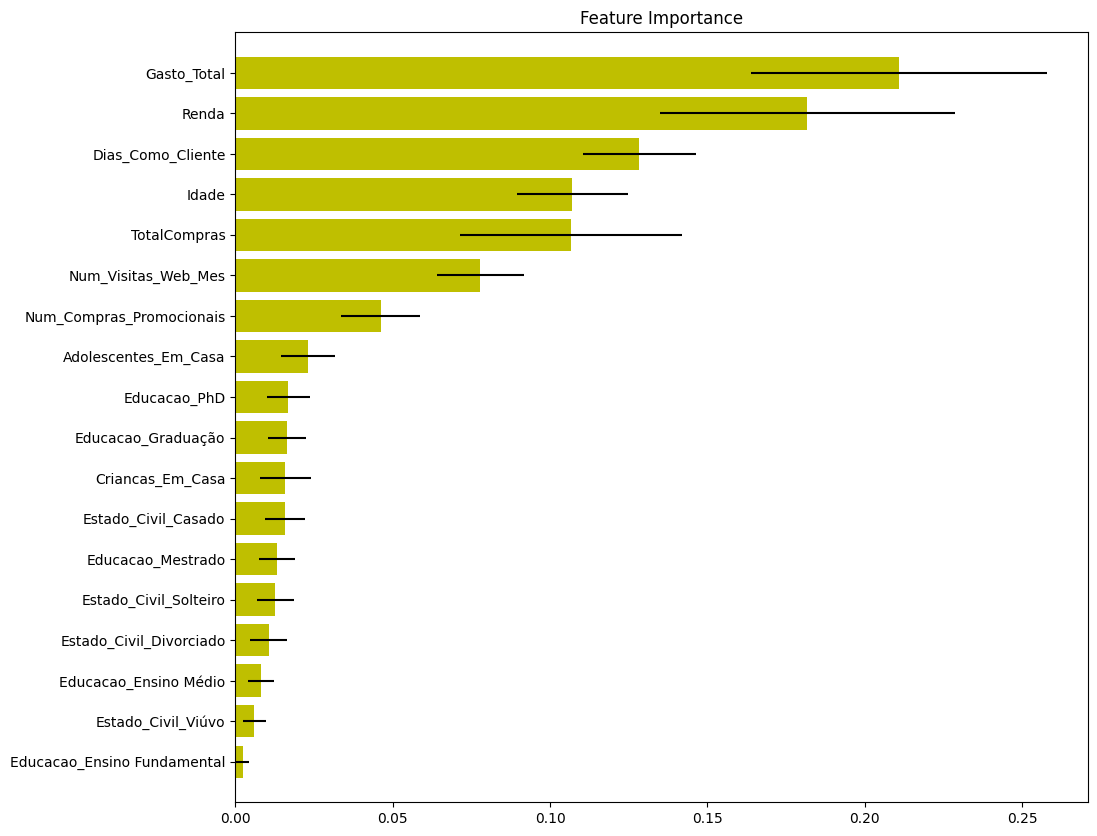

In [85]:
# Plot
plt.figure(1, figsize = (11, 10))
plt.title("Feature Importance")
plt.barh(range(X.shape[1]), importances[indices], color = "y", xerr = std[indices], align = "center")
plt.yticks(range(X.shape[1]), X.columns[indices])
plt.ylim([-1, X.shape[1]])
plt.show()

**Figure 16 - Feature importance in the model.**
Interpretation: Ranks the most relevant variables for explaining campaign response.

## Hypothesis Testing

The analysis suggests that education level has little relationship with campaign response, while income may be relevant. We test the hypothesis of income differences between customers with and without higher education. First, we explore the distribution by education level.

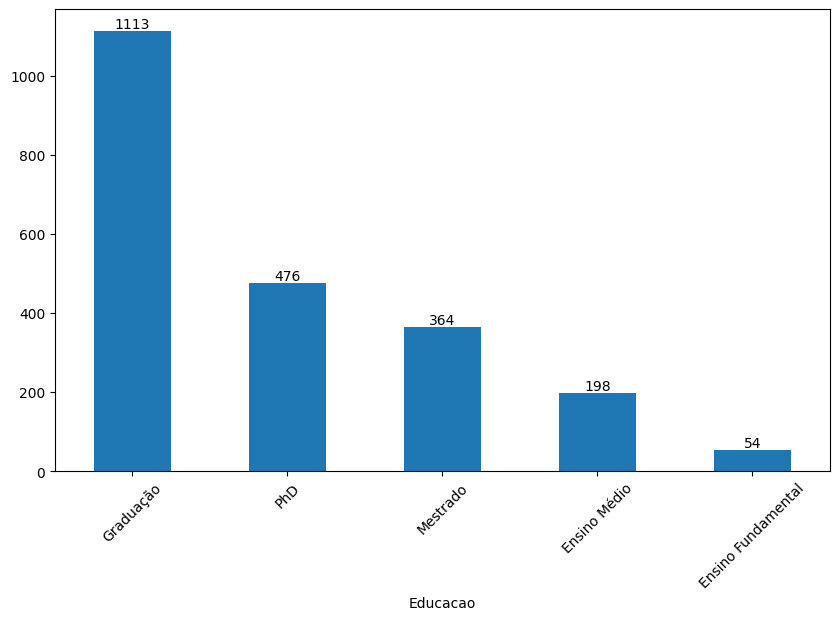

In [86]:
# Plot total customers by education level
plt.figure(figsize = (10, 6))
ax = df.Educacao.value_counts().plot.bar()
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
ax.bar_label(ax.containers[0])
plt.show;

**Figure 17 - Distribution by education level.**
Interpretation: Shows the relative size of each education group in the sample.

In [87]:
df.columns

Index(['ID', 'Educacao', 'Estado_Civil', 'Renda', 'Criancas_Em_Casa',
       'Adolescentes_Em_Casa', 'Gasto_Vinhos', 'Gasto_Frutas', 'Gasto_Carnes',
       'Gasto_Peixes', 'Gasto_Doces', 'Gasto_Outros',
       'Num_Compras_Promocionais', 'Num_Compras_Web', 'Num_Compras_Catalogo',
       'Num_Compras_Loja', 'Num_Visitas_Web_Mes', 'Aceitou_Campanha_1',
       'Aceitou_Campanha_2', 'Aceitou_Campanha_3', 'Aceitou_Campanha_4',
       'Aceitou_Campanha_5', 'Aceitou_Campanha_6', 'Idade',
       'Dias_Como_Cliente', 'TotalCompras', 'Gasto_Total', 'RespostaCampanha'],
      dtype='object')

In [88]:
# Compute the mean
mean_income = df.groupby('Educacao')['Renda'].mean().reset_index()
mean_income = mean_income.sort_values(by = 'Renda')

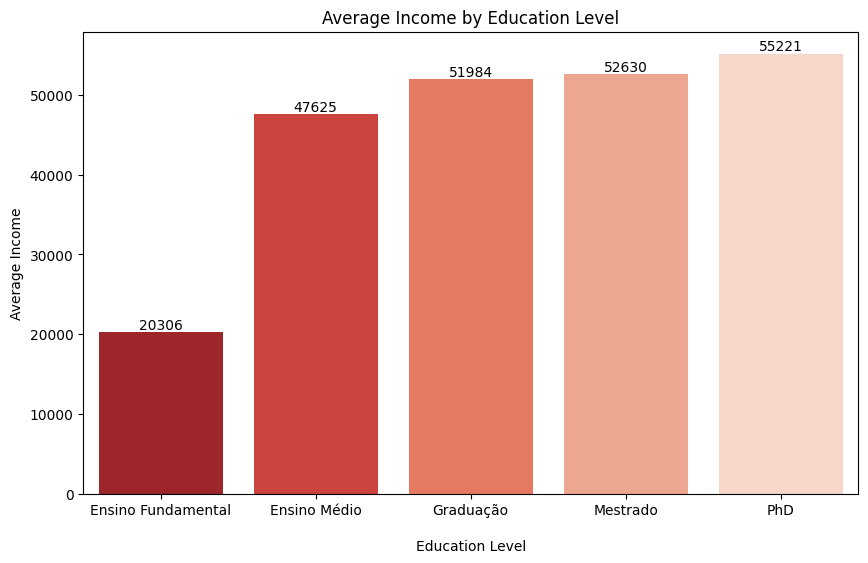

In [89]:
# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x = mean_income['Educacao'], y = mean_income['Renda'], data = df, palette = 'Reds_r')
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha = 'center', 
                va = 'bottom')
plt.xlabel('\nEducation Level')
plt.ylabel('Average Income')
plt.title('Average Income by Education Level')
plt.show()

**Figure 18 - Average income by education level.**
Interpretation: Baseline for comparing income differences across education groups.

### Hypotheses Definition

To select the appropriate test, we check normality. If the data are normal, we use a parametric test; otherwise, a non-parametric test.

**H0**: there is no significant difference between group mean incomes.
**H1**: there is a significant difference between group mean incomes.

In [90]:
# Numeric representation of the categorical variable
df['Educacao'] = df['Educacao'].map({'Ensino Fundamental':1,
                                             'Ensino Médio':2,
                                             'Graduação':3,
                                             'Mestrado':4,
                                             'PhD':5})

In [91]:
df.head()

,ID,Educacao,Estado_Civil,Renda,Criancas_Em_Casa,Adolescentes_Em_Casa,Gasto_Vinhos,Gasto_Frutas,Gasto_Carnes,Gasto_Peixes,...,Aceitou_Campanha_2,Aceitou_Campanha_3,Aceitou_Campanha_4,Aceitou_Campanha_5,Aceitou_Campanha_6,Idade,Dias_Como_Cliente,TotalCompras,Gasto_Total,RespostaCampanha
0,9970,3,Casado,55375.0,0,1,42,11,57,10,...,0,0,0,0,0,49,255,8,162,Not Accepted
1,4002,5,Casado,77037.0,0,1,463,96,333,168,...,0,0,0,0,0,66,259,26,1123,Not Accepted
2,10914,3,Solteiro,24163.0,1,1,4,1,7,2,...,0,0,0,0,0,56,1294,4,17,Not Accepted
3,7279,5,Casado,69476.0,0,0,260,86,559,63,...,0,0,0,0,0,57,272,14,1044,Not Accepted
4,10582,3,Casado,72063.0,0,1,180,32,348,76,...,0,0,0,0,0,47,2665,19,758,Not Accepted


In [92]:
# Data to be tested
data_to_test = df[['Renda', 'Educacao']]

In [93]:
data_to_test.head()

,Renda,Educacao
0,55375.0,3
1,77037.0,5
2,24163.0,3
3,69476.0,5
4,72063.0,3


### Normality Test (Shapiro-Wilk)

The Shapiro-Wilk test assesses normality.

**H0**: the data follow a normal distribution.
**H1**: the data do not follow a normal distribution.

In [94]:
# Shapiro-Wilk test
def testa_normal(columns):
    
    for column in columns:
        
        statistic, p_value = shapiro(data_to_test[column])

        alpha = 0.05
        
        if p_value < alpha:
             print(f'\n{column}: alpha {alpha} < p-value {p_value:.2f} - Reject H0 (Shapiro-Wilk): data are not normally distributed.')
        else:
             print(f'\n{column}: alpha {alpha} > p-value {p_value:.2f} - Fail to reject H0 (Shapiro-Wilk): data follow a normal distribution.')

In [95]:
testa_normal(data_to_test)


Renda: alpha 0.05 < p-value 0.00 - Reject H0 (Shapiro-Wilk): data are not normally distributed.

Educacao: alpha 0.05 < p-value 0.00 - Reject H0 (Shapiro-Wilk): data are not normally distributed.


### Non-Parametric Test (Mann-Whitney U)

The Mann-Whitney U test compares two independent groups when normality is not met, serving as a non-parametric alternative to the t-test.

In [96]:
# Creating the groups
group_with_degree = df[df['Educacao'].isin([5, 4, 3])]['Renda']
group_without_degree = df[df['Educacao'].isin([1, 2])]['Renda']

In [97]:
# Mann-Whitney U test
statistic, p_value = mannwhitneyu(group_with_degree, group_without_degree)

# Significance level
alpha = 0.05

# Resultado
if p_value < alpha:
    print("We rejected the null hypothesis: There is a significant difference in mean income.")
else:
    print("We failed to reject the null hypothesis: There is no significant difference in mean income.")

We rejected the null hypothesis: There is a significant difference in mean income.
